# Simple Regression
Goal: Predicting Matathon Running Time from Age

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Load the dataset
df = pd.read_csv('marathon.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1391 entries, 0 to 1390
Data columns (total 11 columns):
Rank                  1391 non-null int64
Bib                   1391 non-null int64
LastName              1391 non-null object
FirstName             1391 non-null object
Team                  1391 non-null object
Nationality           1391 non-null object
Category              1391 non-null object
PositionInCategory    1391 non-null int64
PositionInGenre       1391 non-null int64
OfficialTime          1391 non-null object
Delay                 1391 non-null object
dtypes: int64(4), object(7)
memory usage: 119.6+ KB


In [3]:
# Analyzing dataset structure
instance_count, attr_count = df.shape
print('Number of instances: %d' % instance_count)
print('Number of attributes: %d' % attr_count)
print('Column names: %s' %  ', '.join(df.columns))

Number of instances: 1391
Number of attributes: 11
Column names: Rank, Bib, LastName, FirstName, Team, Nationality, Category, PositionInCategory, PositionInGenre, OfficialTime, Delay


In [4]:
df.sample(5)

,Rank,Bib,LastName,FirstName,Team,Nationality,Category,PositionInCategory,PositionInGenre,OfficialTime,Delay
1236,1238,1149,e737f62f1b82cddc124922636d805af4e2c05b89637e86...,ae98a0dad2e6beeb7bd921627e46c83c041ab31f5ceb6f...,6720d1fe053158dfeb45752662e1d43f624b8c8c734168...,ita,SF40,47,186,4:41:43,+2:17:43
423,425,455,2d82d11a0c1443edf9ac4a1e336321621e95794c67759a...,4cd4c506709cfe47b5dd19bd09e32348a31cdef45fa9ff...,55a189aa033fb711f7c6ec7bba03eb90b3d6fea3eea79f...,ita,SM45,90,397,3:28:35,+1:04:35
203,204,72,77a60a268d2ad26706ea7ac219e75c96513b16d74f0f3b...,e464b70d883f7ca84aa01f837402f98b24f7142b3b26de...,343080899f9dc62ef7194e656101ba1e27b76d31b09097...,esp,SM,41,194,3:10:39,+46:39
709,711,669,191baa984e766d699966eb999b3bb25186ae04e363431f...,bc715a02358f3e80932665ef08094a7e832b1b908c27ba...,7531890be9d2d3719bc97758760eb98c119b8bb363f288...,ita,SM45,156,657,3:46:41,+1:22:41
1351,1353,406,a9b16cdec12e41975669fd6b487cbf2e3db1ae9ab99276...,2b130b2611062a1a33375b8053cf1e3daec078613e3b56...,25deb62179cdcc3f640a56b947b2f3b10b1f515258866d...,fra,SM,124,1136,5:35:39,+3:11:39


# Preprocessing
Create more interesting variables

In [5]:
def Genre(category):
    '''Computes the genre from the FIDAL running category
    http://www.fidal.it/content/Le-categorie-di-tesseramento-atleti/49913
    '''
    if category==None:
        return
    if category=='PM' or category=='SM':
        return 'Male'
    elif category=='PF' or category=='SF':
        return 'Female'
    elif str(category)[0:2]=='SM':
        return 'Male'
    else:
        return 'Female'

In [6]:
def Age(category):
    '''Computes the age from the FIDAL running category
    http://www.fidal.it/content/Le-categorie-di-tesseramento-atleti/49913
    '''

    if category==None:
        return 0.0

    # promesse
    if category=='PM' or category=='PF':
        return 20.0

    # senior < 35
    if category=='SM' or category=='SF':
        return 23.0

    s = str(category)

    return float(s[2:4])

In [7]:
def MaxAge(category):
    '''Computes the upper bound to runner's age from the FIDAL running category
    http://www.fidal.it/content/Le-categorie-di-tesseramento-atleti/49913
    '''

    if category==None:
        return 0.0

    # promesse
    if category=='PM' or category=='PF':
        return 22.0

    # senior < 35
    if category=='SM' or category=='SF':
        return 35.0

    s = str(category)

    return float(s[2:4])+4

In [8]:
def ConvertTimeToSeconds(time_string):
    '''Computes the running time from hh:mm:ss format'''

    st = str(time_string).split(':')

    # less than a minute
    if (len(st)==1):
        st = ['0'] + st

    # less than a hour
    if (len(st)==2):
        st = ['0'] + st

    return float(st[0])*3600 + float(st[1])*60 +float(st[2])

In [9]:
def ConvertDelay(dt):
    '''Computes the delay from the first runner time from +hh:mm:ss format'''
    return ConvertTimeToSeconds(str(dt)[1:])

In [10]:
def PreprocessRunnersStats(df, distance=42.198):
    cdf = df
    cdf['Age'] = cdf['Category'].apply(Age)
    cdf['MaxAge'] = cdf['Category'].apply(MaxAge)
    cdf['Genre'] = cdf['Category'].apply(Genre)
    cdf['TimeInSeconds'] = cdf['OfficialTime'].apply(ConvertTimeToSeconds)
    cdf['TimeInHours'] = cdf['TimeInSeconds']/3600.0
    cdf['MinutesPerKm'] = (cdf['TimeInSeconds']/60.0)/distance
    cdf['DelayInSeconds'] = cdf['Delay'].apply(ConvertDelay)
    return cdf

In [11]:
df = PreprocessRunnersStats(df)

First, we plot the raw data to get an idea of what we are dealing with.

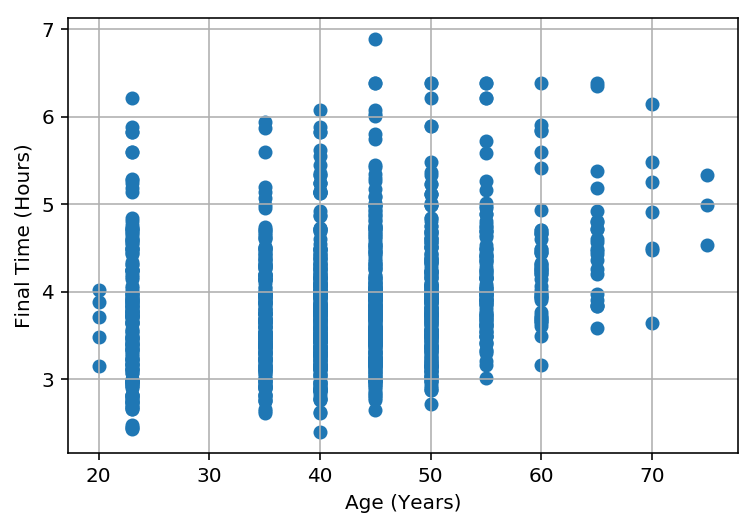

In [12]:
plt.xlabel("Age (Years)")
plt.ylabel("Final Time (Hours)")
plt.scatter(df['Age'], df['TimeInHours'])
plt.grid()

The points are aligned based on age groups for instance, all the data for runners between 35 and 39 appears on the same line since the marathon registration cluster runners in such classes. More information about the age categories are available at, http://www.fidal.it/content/Le-categorie-di-tesseramento-atleti/49913

These points cannot be used for ordinary least square linear regression since of the same input x we have multiple outputs. So for the very first analysis we compute the average running time and try to build a model that predicts that value. For this purpose, we use a function that given the data computes several statistics.

In [13]:
def ComputeStats(df, target):

    age = []
    q1 = []
    q2 = []
    q3 = []
    avg = []
    stddev = []
    stderr = []

    unique_age = sorted(df['Age'].unique())

    for a in unique_age:
        # selected data
        sd = np.array(df[df['Age']==a][target])

        age.append(a)
        q1.append(np.percentile(sd,25))
        q2.append(np.percentile(sd, 50))
        q3.append(np.percentile(sd, 75))
        avg.append(np.average(sd))
        stddev.append(np.std(sd))
        stderr.append(np.std(sd)/len(sd))
        
    return pd.DataFrame({'Age':age, 'FirstQuartile':q1, 'SecondQuartile':q2, 'ThirdQuartile':q3, 'Average':avg, 'StdDev':stddev, 'StdErr':stderr})


In [14]:
qdf = ComputeStats(df,'TimeInHours')
qdf

,Age,Average,FirstQuartile,SecondQuartile,StdDev,StdErr,ThirdQuartile
0,20.0,3.649167,3.478889,3.709444,0.306483,0.061297,3.881111
1,23.0,3.737560,3.154514,3.710139,0.772945,0.004601,4.246389
2,35.0,3.704929,3.293889,3.607222,0.597854,0.002730,4.116250
3,40.0,3.792429,3.369167,3.736944,0.637603,0.002176,4.091389
4,45.0,3.828979,3.391042,3.690417,0.686963,0.002290,4.072986
5,50.0,3.899531,3.418056,3.801389,0.669697,0.003072,4.239861
6,55.0,4.165720,3.711667,4.018611,0.669162,0.006373,4.439167
7,60.0,4.335983,3.927639,4.241250,0.668317,0.013366,4.572292
8,65.0,4.589287,4.086111,4.488333,0.705645,0.030680,4.802500
9,70.0,4.914603,4.487361,4.915278,0.747131,0.106733,5.361528


Let's plot the average running time.

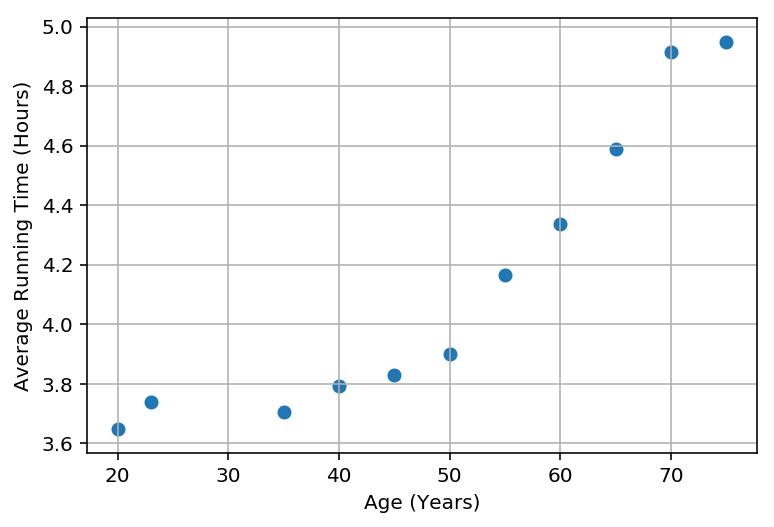

In [15]:
plt.xlabel("Age (Years)")
plt.ylabel("Average Running Time (Hours)")
plt.scatter(qdf['Age'], qdf['Average'])
plt.grid()

# Linear Regression Model

In [16]:
from sklearn import linear_model

x1 = np.array(qdf['Age'])
y1 = qdf['Average']

# Needed by the new scikit-learn version
x1 = x1.reshape(-1,1)

# Build the regression model using Ordinary Least Squares (OLS)
regr = linear_model.LinearRegression()
regr.fit(x1, y1)

yp = regr.predict(x1)

rss = round(sum((y1-yp)**2),3)

/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


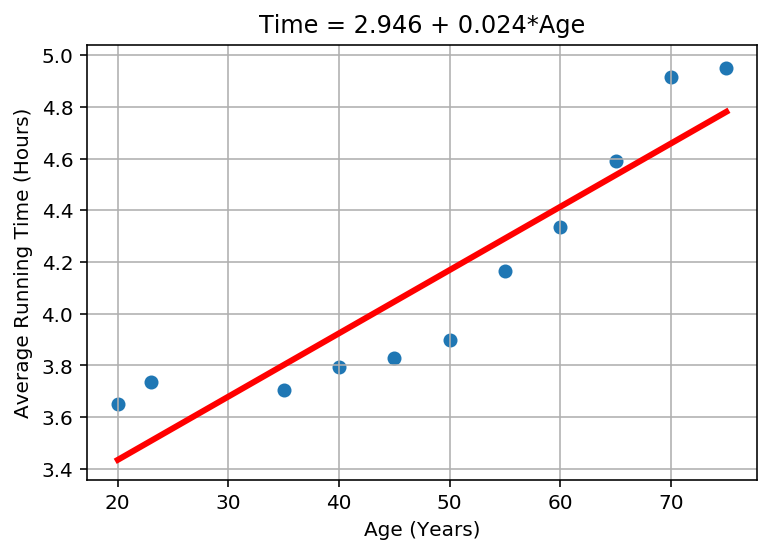

In [17]:
plt.xlabel("Age (Years)")
plt.ylabel("Average Running Time (Hours)")
plt.scatter(qdf['Age'], qdf['Average'])
plt.plot(x1,yp, color='red',linewidth=3)
plt.grid()

coeff = round(regr.coef_[0],3)
intercept = round(regr.intercept_,3)

eq = "Time = " + str(intercept)
if (coeff>0):
    eq = eq + " + "
eq = eq + str(coeff)+"*Age"
plt.title (eq)

## Questions
- What is the practical meaning of the intercept?
- What is the practical meaning of the coefficient?
- Do you foresee any issue about these two terms?

## Enriching Data with Domain Knowledge
We know that the age categories group together people of different ages. For example, SM_35 is associated to males between the are of 35 and 40 excluded. Thus, the data we plotted at the beginning are not a correct representation of our data. We can insert what we know about the age groups to the training data. We modify the age of individuals by randomly generating an age from the corresponding interval. For instance, we substitute an age of 35 with a random age selected between 35 and 40 (excluded).

In [18]:
import random 

def JitterAge(age):
    if (age>=35):
        return age + random.uniform(0,5)
    if (age==20):
        return age + random.uniform(0,2)
    if (age==23):
        return age + random.uniform(0,12)


df['Age'] = df['Age'].apply(JitterAge)

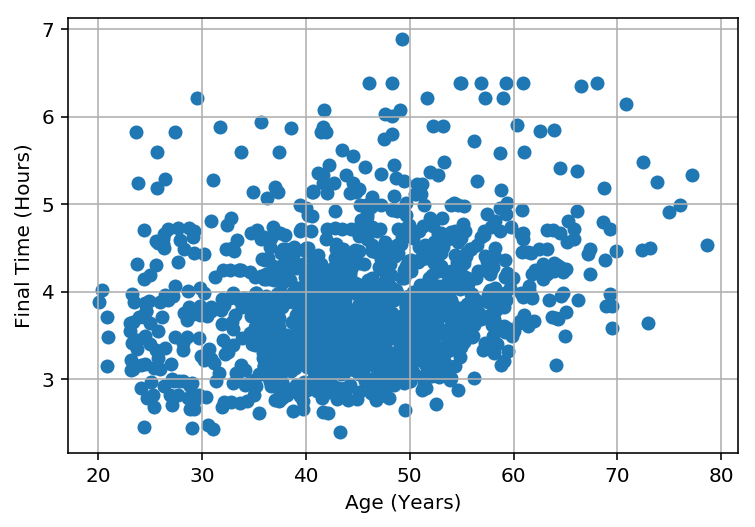

In [19]:
plt.xlabel("Age (Years)")
plt.ylabel("Final Time (Hours)")
plt.scatter(df['Age'], df['TimeInHours'])
plt.grid()

# Linear Regression Model 2

In [20]:
x2 = df['Age']
y2 = df['TimeInHours']

# Needed by the new scikit-learn version
x2 = x2.values.reshape(-1,1)

# Build the regression model using OLS
regr = linear_model.LinearRegression()
regr.fit(x2, y2)

# Predicted y
jittered_prediction = regr.predict(x2)

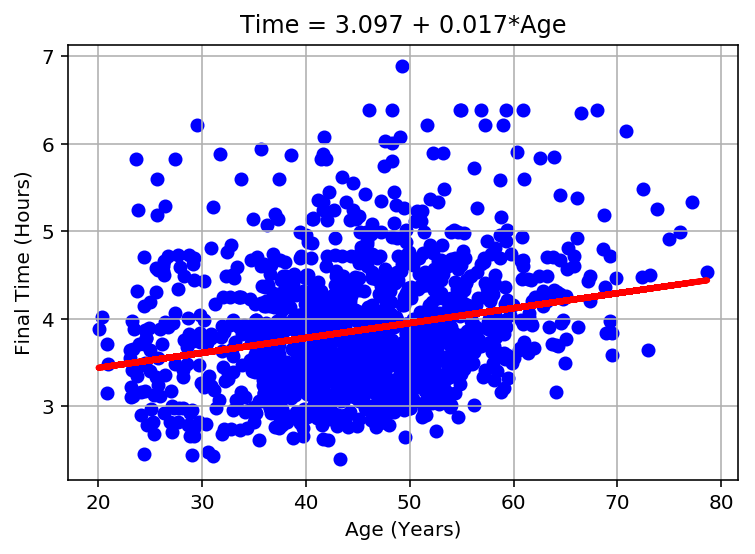

In [21]:
plt.xlabel("Age (Years)")
plt.ylabel("Final Time (Hours)")
plt.scatter(x2, y2, color='blue')
plt.plot(x2,jittered_prediction, color='red',linewidth=3)
plt.grid()

coeff = round(regr.coef_[0],3)
intercept = round(regr.intercept_,3)

eq = "Time = " + str(intercept)
if (coeff>0):
    eq = eq + " + "
eq = eq + str(coeff)+"*Age"

plt.title (eq)